# Lab 5 - Support Vector Machines

In this lab we will solve a classification problem using a Support Vector Machine (SVM). As you have seen in class one intuition for introducing this popular model comes from Logistic Regression (LR). In fact the loss of the SVM can be seen also as an approximation of the (regularized) LR loss.

* Logistic Regression Loss (regularized): 

$$J_{LR}(\theta) = \frac{1}{M}\sum_{i=1}^M y^{(i)} \log(h_{\theta}(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)})) + \frac{\lambda}{2M}\sum_{j=1}^N \theta^2_{j} $$

* Support Vector Machine Loss: 

$$J_{SVM}(\theta) = C\sum_{i=1}^M y^{(i)} max(0, 1 - h_{\theta}(x)) + (1 - y^{(i)}) max(0, 1 + h_{\theta}(x)) + \frac{1}{2}\sum_{j=1}^N \theta^2_{j} $$



<img src="https://i.ibb.co/SNKS81J/Screenshot-2020-05-26-at-6-42-35-PM.png" alt="" border="0" width="100%">


where the SVM hypothesis is:

$$h_{\theta}(x) = \theta^T x$$

and the final prediction is:

$$\hat{y}_{\theta}(x) = \mathbb{1}\{h_{\theta}(x) \geq 0\} = \mathbb{1}\{\theta^T x \geq 0\}$$

(Remember that $x$ in this notation has the 1 appended on the last dimension)

In [74]:
##################################################
# Imports
##################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.datasets.samples_generator import make_blobs

# Settings
plt.style.use('seaborn')

In [75]:
##################################################
# Parameters
##################################################

SEED = 12345
TRAIN_RATIO = 0.6

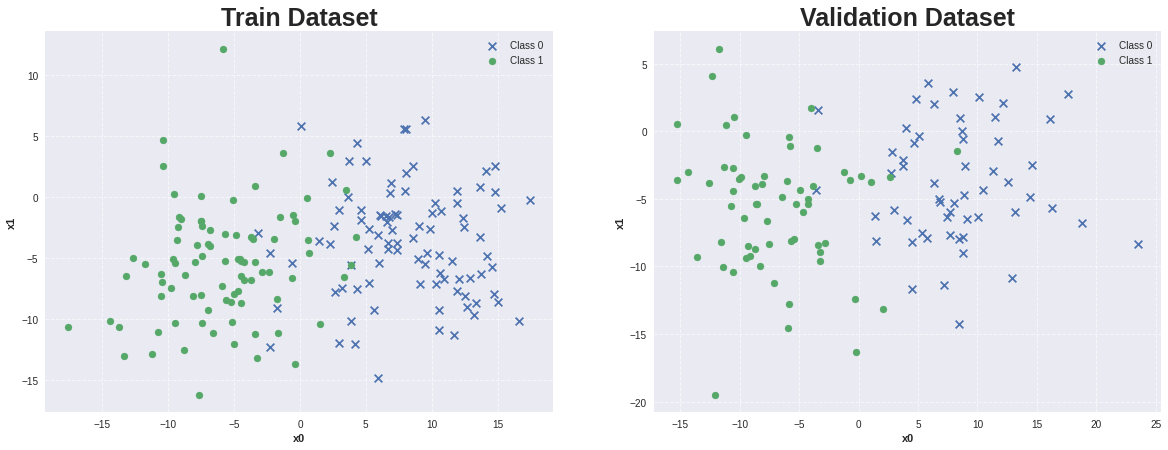

In [76]:
##################################################
# Dataset
##################################################

x_raw, y = make_blobs(n_samples=300, centers=2, random_state=SEED, cluster_std=4.60)

# Split into train and validation set
n_tr = int(np.ceil(len(x_raw) * TRAIN_RATIO))
idx_samples = np.arange(len(x_raw))
np.random.seed(SEED)
np.random.shuffle(idx_samples)
x_train_raw, y_train = x_raw[idx_samples[:n_tr]], y[idx_samples[:n_tr]]
x_validation_raw, y_validation = x_raw[idx_samples[n_tr:]], y[idx_samples[n_tr:]]

# Plot the dataset
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.title('Train Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_train_raw) if y_train[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_train_raw) if y_train[i] == 0], 
            label='Class 0', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_train_raw) if y_train[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_train_raw) if y_train[i] == 1], 
            label='Class 1')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Validation Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 0], 
            label='Class 0', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_validation_raw) if y_validation[i] == 1], 
            label='Class 1')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.legend()

plt.show()

## Preprocess the dataset

* **Normalization**: in this way our dataset has zero mean and unit scalar deviation (important for the optimization step)

$$x_i \leftarrow \frac{x_i - \mu_x}{\sigma_x} \ \ \forall i$$

* **Append $1$ to $x$**: in this way we include the bias in the parameter vector

$$x_i \leftarrow [x_i, 1]  \ \ \forall i$$

In [77]:
##################################################
# Pre-process dataset
##################################################

# Normalize the dataset
x_mu, x_std = x_train_raw.mean(axis=0), x_train_raw.std(axis=0)
x_train = (x_train_raw - x_mu) / x_std
x_validation = (x_validation_raw - x_mu) / x_std

# Append ones column
x_train = np.concatenate([x_train, np.ones([len(x_train), 1], dtype=np.float32)], axis=-1)
x_validation = np.concatenate([x_validation, np.ones([len(x_validation), 1], dtype=np.float32)], axis=-1)

# Reshape target
y_train = y_train.reshape(-1, 1)
y_validation = y_validation.reshape(-1, 1)

# SVM Model

Here there is a class that implement a Support Vector Machine. In this lab we will train this model using Stochastic Gradiend Descent. The gradient is already implemented but here you can find how to compute it.

For the $i^{th}$ data point we have (the $i^{th}$ index is omitted for simplifing the notation):


$$\frac{\partial J_{SVM} (\theta)}{\partial \theta} = \frac{\partial J_{SVM}}{\partial h_{\theta} (x)} \frac{\partial h_{\theta} (x)}{\partial \theta} = (1 - y)\mathbb{1}\{ h \geq -1 \} - y\mathbb{1}\{h \leq 1\}$$

In [104]:
##################################################
# SVM Class
##################################################

class SVM(object):
    def __init__(self, theta_dim=3, seed=1234):
        np.random.seed(seed)
        self.theta = np.random.normal(loc=0.01, size=[theta_dim, 1]) # shape [theta_dim, 1]
        self.theta[-1] = 0 # Zero initialization for the bias

    def forward(self, x):
        '''
        input x: ndarray of shape [N, theta_dim]
        output h: ndarray of shape [N, 1]
        '''
        h = None
        ##############################
        # INSERT YOUR CODE HERE
        ##############################
        h = np.dot(x, self.theta)
        ##############################
        # END OF YOUR CODE
        ##############################
        return h

    def loss(self, h, y, C):
        '''
        input h: ndarray of shape [N, 1]
        input y: ndarray of shape [N, 1]
        output j: scalar
        '''
        j = None
        ##############################
        # INSERT YOUR CODE HERE
        ##############################
        j = C * ((y * np.maximum(0, 1 - h)) + ((1-y) *np.maximum(0, 1+ h))).sum() + 1/2 * np.sum(self.theta**2)
        #j = C * (y.T.dot(np.maximum(0, 1-h)) + (1-y).T.dot(np.maximum(0, 1 + h))) + 1/2 * np.sum(self.theta**2)
        #print(j[0,0])
        ##############################
        # END OF YOUR CODE
        ##############################
        return j
        #return j[0,0]

    def fit(self, x, y, x_val, y_val, C=1, lr=1e-3, iterations=100, print_every=10, batch_size=32, seed=1234):
        '''
        input x: ndarray of shape [N, theta_dim]
        input y: ndarray of shape [N, 1]
        '''
        idx_samples = np.arange(len(x))
        loss = {'train': [], 'validation': []}
        for it in range(iterations):

            # Batches
            np.random.seed(seed)
            np.random.shuffle(idx_samples)
            num_batches = int(np.ceil(len(x) / batch_size))
            loss_epoch = []
            for idx_b in range(num_batches):
                idx_batch = idx_samples[idx_b * batch_size : (idx_b + 1) * batch_size]
                x_batch, y_batch = x[idx_batch], y[idx_batch]

                # Forward and loss
                h = self.forward(x_batch) # shape [batch_size,]
                loss_epoch += [self.loss(h, y_batch, C=C)]
            
                # Compute the gradient
                grad = 1.0 * (y_batch == 0) * (h >= -1) - 1.0 * (y_batch == 1) * (h <= 1)
                grad = C * (np.tile(grad, (1, x_batch.shape[-1])) * x_batch).sum(axis=0, keepdims=True).T
                grad = grad + self.theta

                # Update the gradient
                self.theta = self.theta - lr * grad

            loss['train'] += [np.mean(loss_epoch)]

            # Validation step
            h_val = self.forward(x_val)
            loss['validation'] += [self.loss(h_val, y_val, C=C)]

            # Print log
            if print_every is not None:
                if (it % print_every == 0) or (it == iterations - 1):
                    print(f'Iter: {it}\n\ttrain loss {loss["train"][-1]:.3f}, validation loss {loss["validation"][-1]:.3f}')
        return loss

    def predict(self, x):
        '''
        input x: ndarray of shape [N, theta_dim]
        output y_: ndarray of shape [N, 1]
        '''
        y_ = None
        ##############################
        # INSERT YOUR CODE HERE
        ##############################
        h = self.forward(x)
        y_ = 1 * (h>=0) 
        ##############################
        # END OF YOUR CODE
        ##############################
        return y_

    def evaluate(self, x, y, metric_func):
        '''
        input x: ndarray of shape [N, theta_dim]
        input y: ndarray of shape [N, 1]
        input metric_func: function for evaluation
        '''
        y_ = self.predict(x)
        return metric_func(y_, y)

# Train the SVM

In [105]:
# Create and fit a SVM
svm = SVM()
loss = svm.fit(x_train, y_train, x_validation, y_validation, C=3, lr=1e-4, iterations=2000, print_every=100)

Iter: 0
	train loss 112.806, validation loss 459.586
Iter: 100
	train loss 22.225, validation loss 70.554
Iter: 200
	train loss 19.515, validation loss 61.759
Iter: 300
	train loss 18.836, validation loss 58.837
Iter: 400
	train loss 18.692, validation loss 58.119
Iter: 500
	train loss 18.631, validation loss 57.558
Iter: 600
	train loss 18.587, validation loss 57.424
Iter: 700
	train loss 18.572, validation loss 57.425
Iter: 800
	train loss 18.573, validation loss 57.390
Iter: 900
	train loss 18.572, validation loss 57.384
Iter: 1000
	train loss 18.579, validation loss 57.367
Iter: 1100
	train loss 18.574, validation loss 57.351
Iter: 1200
	train loss 18.571, validation loss 57.322
Iter: 1300
	train loss 18.575, validation loss 57.322
Iter: 1400
	train loss 18.572, validation loss 57.309
Iter: 1500
	train loss 18.571, validation loss 57.296
Iter: 1600
	train loss 18.570, validation loss 57.292
Iter: 1700
	train loss 18.570, validation loss 57.273
Iter: 1800
	train loss 18.574, validat

In [102]:
# Accuracy
from sklearn.metrics import accuracy_score
def accuracy(y_, y):
    return (y_ == y).mean()

# Evaluate
acc_train = svm.evaluate(x_train, y_train, accuracy)
acc_validation = svm.evaluate(x_validation, y_validation, accuracy)
print(f'Train accuracy {100 * acc_train:.2f}%, validation accuracy {100 * acc_validation:.2f}%')

Train accuracy 92.22%, validation accuracy 95.00%


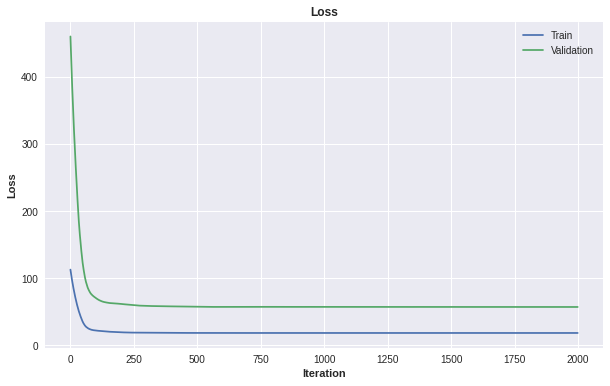

In [103]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.title('Loss', fontweight='bold')
for key, l in loss.items():
    plt.plot(l, label=key.capitalize())
plt.legend()
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.show()

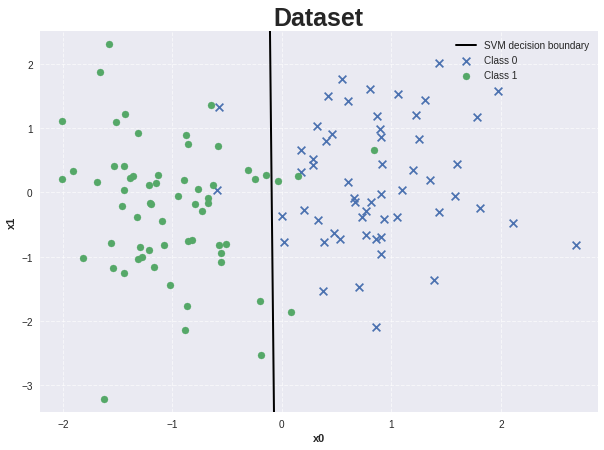

In [58]:
# Plot the decision boundary
a, b, c = svm.theta.copy()
x_in = np.linspace(-2, 2, 100)

plt.figure(figsize=(10, 7))
plt.plot(x_in, - a / b * x_in - c / b, c='k', label='SVM decision boundary', lw=2)
plt.title('Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], 
            label='Class 0', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 1], 
            label='Class 1')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.xlim(x_validation[:, 0].min() - 0.2, x_validation[:, 0].max() + 0.2)
plt.ylim(x_validation[:, 1].min() - 0.2, x_validation[:, 1].max() + 0.2)
plt.legend()
plt.show()

# Changing the $C$ parameter

Here you can see the impact of the parameter $C$ in respect to the decision boundary fo the SVM. 

In [59]:
# Search for C
svms, losses = {}, {}
for c in [0.05, 0.1, 0.5, 0.8, 1, 1.5, 5]:
    print(f'Fitting svm with C = {c}')
    svms[c] = SVM()
    losses[c] = svms[c].fit(x_train, y_train, x_validation, y_validation, C=c, lr=1e-4, iterations=2000, print_every=None)

Fitting svm with C = 0.05
Fitting svm with C = 0.1
Fitting svm with C = 0.5
Fitting svm with C = 0.8
Fitting svm with C = 1
Fitting svm with C = 1.5
Fitting svm with C = 5


In [60]:
# Evaluate
accs = {}
for c, svm in svms.items(): 
    acc = svm.evaluate(x_validation, y_validation, accuracy)
    accs[c] = acc
    print(f'C = {c}, validation accuracy {100 * acc:.2f}%')

C = 0.05, validation accuracy 90.00%
C = 0.1, validation accuracy 94.17%
C = 0.5, validation accuracy 95.00%
C = 0.8, validation accuracy 95.00%
C = 1, validation accuracy 95.00%
C = 1.5, validation accuracy 95.00%
C = 5, validation accuracy 95.00%


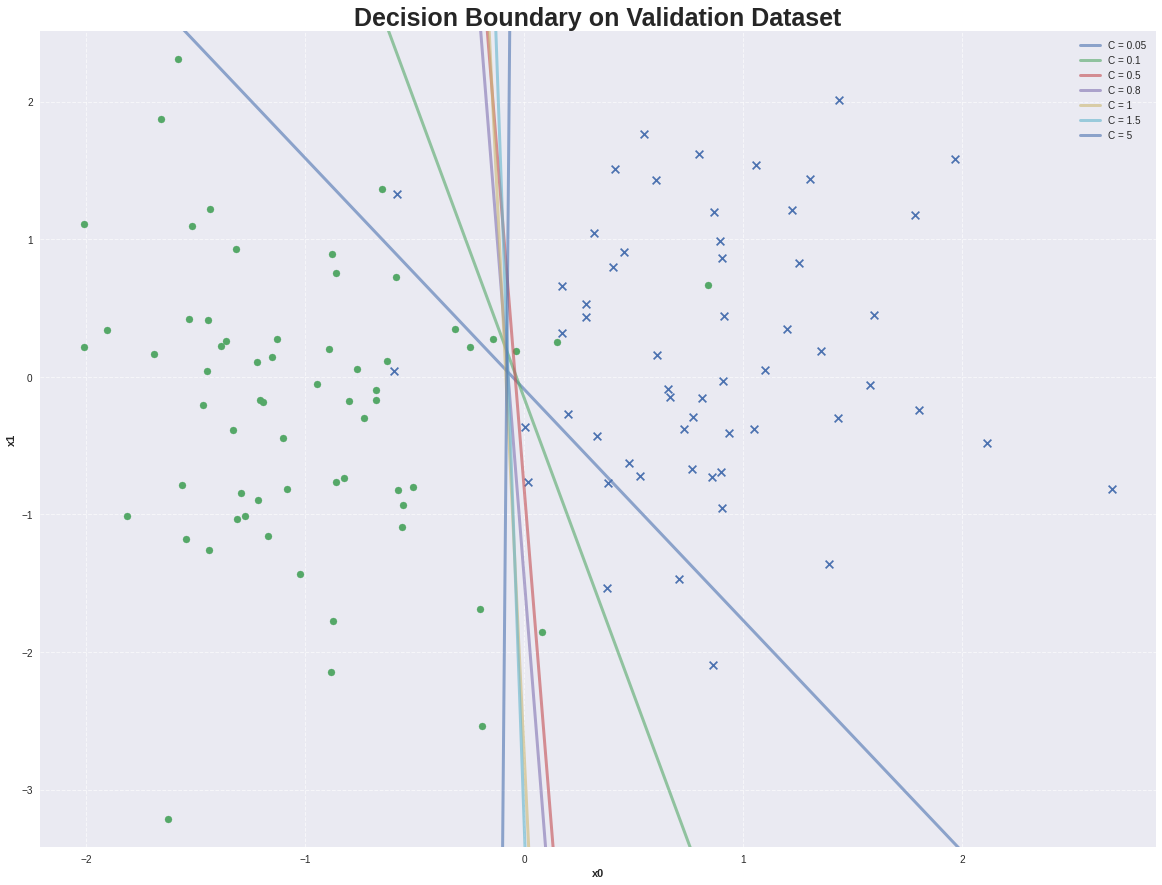

In [61]:
# Plot the decision boundary
x_in = np.linspace(-2, 2, 100)
plt.figure(figsize=(20, 15))
for key, svm in svms.items():
    a, b, c = svm.theta.copy()
    plt.plot(x_in, - a / b * x_in - c / b, label=f'C = {key}', lw=3, alpha=0.6)
plt.title('Decision Boundary on Validation Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 0], s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_validation) if y_validation[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_validation) if y_validation[i] == 1])
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('x0', fontweight='bold')
plt.ylabel('x1', fontweight='bold')
plt.xlim(x_validation[:, 0].min() - 0.2, x_validation[:, 0].max() + 0.2)
plt.ylim(x_validation[:, 1].min() - 0.2, x_validation[:, 1].max() + 0.2)
plt.legend()
plt.show()